In [5]:
exec(open("inc_notebook.py").read())

FileNotFoundError: [Errno 2] No such file or directory: 'inc_notebook.py'

In [4]:
import logging, sys, math,os
exec(open("estimator/initKeras.py").read())

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

if sys.modules.get( 'library.LivePlotKeras', False ) != False :
    del sys.modules['library.LivePlotKeras'] 
if sys.modules.get( 'LivePlotKeras', False ) != False :
    del sys.modules['LivePlotKeras'] 
from library.LivePlotKeras import *

logging.warning( "LivePlotKeras loaded" )

livePlotKeras = LivePlotKeras()

In [10]:
if sys.modules.get( 'estimator.EstimatorIO', False ) != False :
    del sys.modules['estimator.EstimatorIO'] 
if sys.modules.get( 'EstimatorIO', False ) != False :
    del sys.modules['EstimatorIO'] 
from estimator.EstimatorIO import *

logging.warning( "EstimatorIO loaded" )

estimatorIO = EstimatorIO()

In [4]:
from embedding.MultipleBinEmbeddingType import *

if sys.modules.get( 'library.MultipleBinDataGenerator', False ) != False :
    del sys.modules['library.MultipleBinDataGenerator'] 
if sys.modules.get( 'MultipleBinDataGenerator', False ) != False :
    del sys.modules['MultipleBinDataGenerator'] 
from library.MultipleBinDataGenerator import *

logging.warning( "MultipleBinDataGenerator loaded" )

trainGenerator = MultipleBinDataGenerator(embedding=MultipleBinEmbeddingType.CNN_STATS, 
                                          batch_size=16, windowSize = 36, stride = 6)

D:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator RobustScaler from version 0.20.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:

model_input = layers.Input( shape = ( 36, 275, 1 ) )
x = layers.Conv2D(64, 
        kernel_size = (5,1), 
        padding = 'same'
        )(model_input)

x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling

x = layers.Conv2D(64, kernel_size=(3,1), padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(16, kernel_size=(3,1), activation=activations.relu, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(1)(x)

model = models.Model(model_input, x, name = "2DCNN-MixedKernel")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 36, 275, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 275, 64)       384       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 275, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 275, 128)      24704     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 36, 275, 128)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 275, 128)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 275, 16)       6160      
__________

In [6]:
model.compile(optimizer=optimizers.Adam(lr=0.001),
             loss = losses.MSE,
             metrics = [metrics.MSE, metrics.MAE])

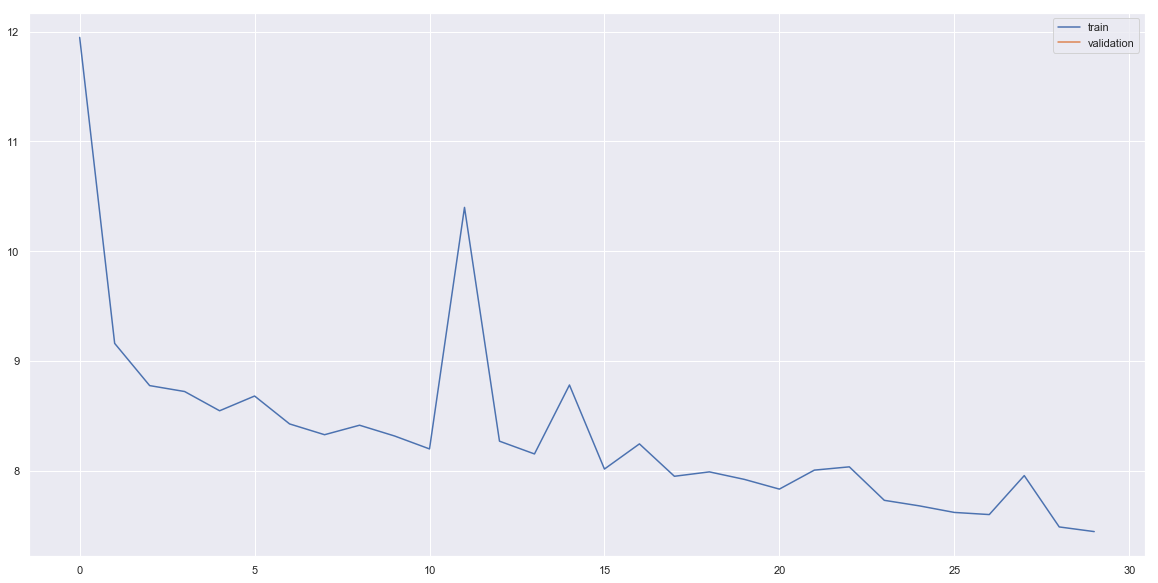

In [7]:
history = model.fit_generator( generator=trainGenerator,
                    use_multiprocessing=False, 
                    workers=3, 
                    initial_epoch = 0,
                    epochs=30,
                    max_q_size = 100,
                    steps_per_epoch = trainGenerator.getNumberOfBatches(),
                    callbacks = [livePlotKeras]
                   )

In [11]:
estimatorIO.save(model, model.name)

In [15]:
if sys.modules.get( 'library.EmbeddingStatsGeneratorForTestPos', False ) != False :
    del sys.modules['library.EmbeddingStatsGeneratorForTestPos'] 
if sys.modules.get( 'EmbeddingStatsGeneratorForTestPos', False ) != False :
    del sys.modules['EmbeddingStatsGeneratorForTestPos'] 
from library.EmbeddingStatsGeneratorForTestPos import *  
logging.warning( "EmbeddingStatsGeneratorForTestPos loaded" )

embeddingType = 'cnn-stats-test'
generator = EmbeddingStatsGeneratorForTestPos(embeddingType = embeddingType)

D:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator RobustScaler from version 0.20.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
import pandas as pd
output = pd.read_csv('F:/myProjects/cmps242/earthquake/data/sample_submission.csv')
dic = {}
for testName, batch in generator.batchesByFile():
    print(f'test: {testName}')
#     print(trainModel.predict(batch, batch_size=generator.numberOfEmbeddingPerFile))
    pred = model.predict(batch, batch_size=generator.numberOfEmbeddingPerFile)
    dic[testName] = pred
#     print( output.index[output['seg_id'] == testName])
    output.at[output.index[output['seg_id'] == testName], 'time_to_failure'] = np.median(pred)

test: seg_00030f
test: seg_0012b5
test: seg_00184e
test: seg_003339
test: seg_0042cc
test: seg_004314
test: seg_004cd2
test: seg_004ee5
test: seg_004f1f
test: seg_00648a
test: seg_006e4a
test: seg_007a37
test: seg_00a37e
test: seg_00be11
test: seg_00c35b
test: seg_00cc91
test: seg_00e5f7
test: seg_00f3b9
test: seg_010eab
test: seg_0125d9
test: seg_0144cb
test: seg_0165c6
test: seg_016913
test: seg_016cdb
test: seg_017314
test: seg_01a8dc
test: seg_01c775
test: seg_01ecb0
test: seg_02042f
test: seg_025e78
test: seg_032822
test: seg_0339ca
test: seg_037461
test: seg_038879
test: seg_03d386
test: seg_03d63e
test: seg_03d680
test: seg_03f380
test: seg_0445d7
test: seg_046c28
test: seg_0488a1
test: seg_049957
test: seg_04a696
test: seg_04ae38
test: seg_04b87a
test: seg_04cceb
test: seg_04ee93
test: seg_04fd93
test: seg_0536c9
test: seg_055127
test: seg_05a1b0
test: seg_05a4ad
test: seg_05b66a
test: seg_05bef4
test: seg_05e0d7
test: seg_05f126
test: seg_05f9d6
test: seg_060ce4
test: seg_061a

test: seg_306756
test: seg_30ad2a
test: seg_30b043
test: seg_30da11
test: seg_30fd84
test: seg_310230
test: seg_31064b
test: seg_311499
test: seg_311b5e
test: seg_3128e6
test: seg_3151ff
test: seg_31631c
test: seg_316f86
test: seg_318135
test: seg_31a51f
test: seg_31a6cd
test: seg_31b808
test: seg_31c0f4
test: seg_31d763
test: seg_31d7bf
test: seg_31d810
test: seg_31ddc5
test: seg_3234ca
test: seg_324447
test: seg_324537
test: seg_325790
test: seg_326eb7
test: seg_327ed4
test: seg_32906d
test: seg_32ad0f
test: seg_32c904
test: seg_32d747
test: seg_32e763
test: seg_32f3a9
test: seg_32f6df
test: seg_32f72d
test: seg_32fc4e
test: seg_330579
test: seg_3319b5
test: seg_331f2b
test: seg_3340b9
test: seg_335170
test: seg_337b8c
test: seg_339f80
test: seg_33c30d
test: seg_342ce6
test: seg_343571
test: seg_3452b2
test: seg_34a2b8
test: seg_34a8f7
test: seg_34abd2
test: seg_34ef79
test: seg_3506d6
test: seg_35269b
test: seg_355717
test: seg_355d19
test: seg_35a2d7
test: seg_35b009
test: seg_35b7

test: seg_63130f
test: seg_633651
test: seg_634180
test: seg_634f05
test: seg_635770
test: seg_63582a
test: seg_63c13d
test: seg_63c518
test: seg_63c8e4
test: seg_63c983
test: seg_63c9a3
test: seg_63d651
test: seg_6422d1
test: seg_643d1f
test: seg_643f86
test: seg_64bcb9
test: seg_64be5d
test: seg_64be91
test: seg_64daae
test: seg_64dcf0
test: seg_64f8dc
test: seg_650de2
test: seg_651808
test: seg_652cc2
test: seg_655780
test: seg_655ad6
test: seg_655cae
test: seg_658bf4
test: seg_659ff8
test: seg_65b962
test: seg_65c4e1
test: seg_65ef95
test: seg_65f01e
test: seg_65fbac
test: seg_660fe1
test: seg_660fef
test: seg_661629
test: seg_666056
test: seg_6681ee
test: seg_66820a
test: seg_6696d0
test: seg_66b7c3
test: seg_66e45a
test: seg_66ed4d
test: seg_670bde
test: seg_67330f
test: seg_673c60
test: seg_67599b
test: seg_679dd2
test: seg_67aa76
test: seg_68102c
test: seg_683ddf
test: seg_686edc
test: seg_687a5c
test: seg_68a484
test: seg_68da94
test: seg_691a72
test: seg_692e7a
test: seg_6951

In [ ]:
output.to_csv(f'F:/myProjects/cmps242/earthquake/data/{model.name}.csv', index=False)